In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
%cd 'Image Tampering '

/content/gdrive/MyDrive/Image Tampering 


In [ ]:
import os 
import cv2
from PIL import Image, ImageChops, ImageEnhance
import numpy as np

In [ ]:
'''
Does ELA on a given image by calculating abs_diff and 
scaling(dynamically brightening, avg extremas)

INPUT: img_path, compression quality for resave 

OUTPUT: ELA
'''

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = sum([ex[1] for ex in extrema])/3
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

**ELA highlights the differences between the JPEG compression level**

There are several factors which can help to  check whether an image has been tampered with or not:

1.  Regions with uniform colouring (eg. Solid wall or sky), should have lower ELA (darker).
 
2.  Similar edges usually have similar brightness. High-contrast edges will look similar to other high-contrast edges, while low-contrast edges will look similar to other low-contrast edges.
3. Similar textures usually exhibit similar colouring.
4. Regardless of the original colour, all flat surfaces have the same colouring.



# **ELA on Real  Images**

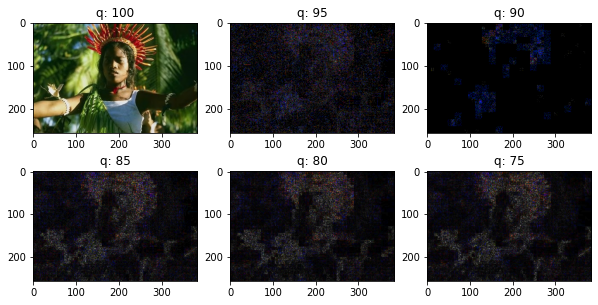

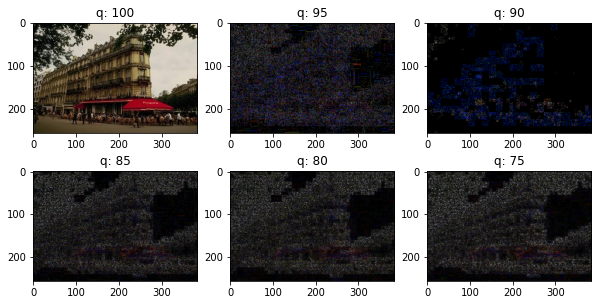

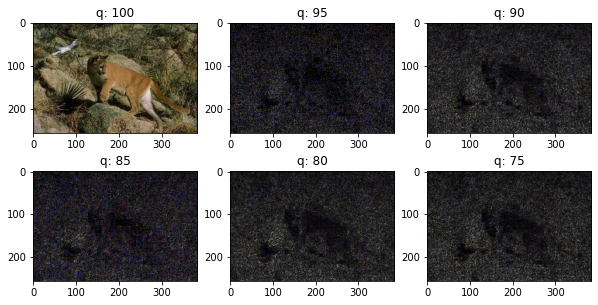

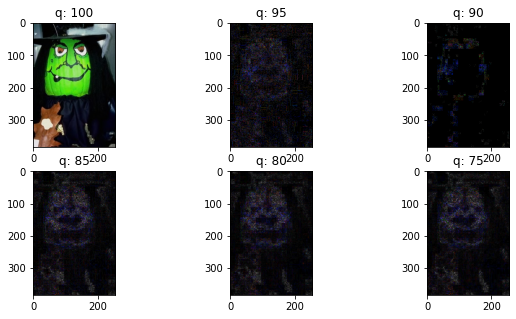

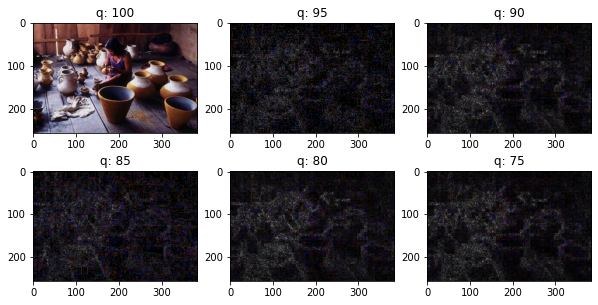

In [ ]:
import matplotlib.pyplot as plt
import random

p = os.path.join('Casia2', 'Real/')
temp = p
p = os.listdir(p)
#print(p)

for i in range(0,5):
    random_img = temp+random.choice(p)
    original = cv2.cvtColor(cv2.imread(random_img),cv2.COLOR_BGR2RGB)/255.0
    init_value  = 100
    c = 3
    r = 2

    fig=plt.figure(figsize=(10, 5))
    for i in range(1, c*r +1):
        quality = init_value - (i-1) * 5
        img = convert_to_ela_image(path=random_img, quality=quality)
        if i == 1:
            img = original.copy()
        ax = fig.add_subplot(r, c, i) 
        ax.title.set_text(f'q: {quality}')
        plt.imshow(img)
    plt.show()

*Result on Real image shows that the edges are quite similar looking. The Surface has consitency in term of textures. Uniform coloured pixels are reduces to lower values.*

# **ELA on Tampered Images**

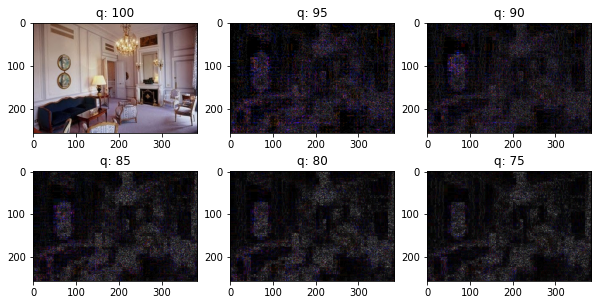

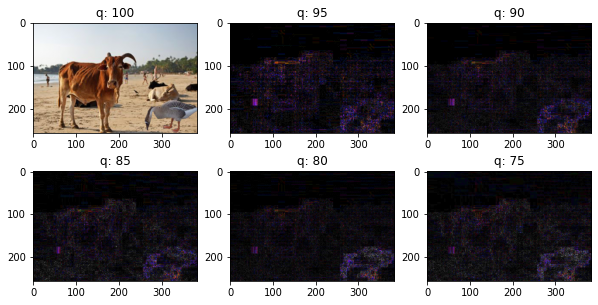

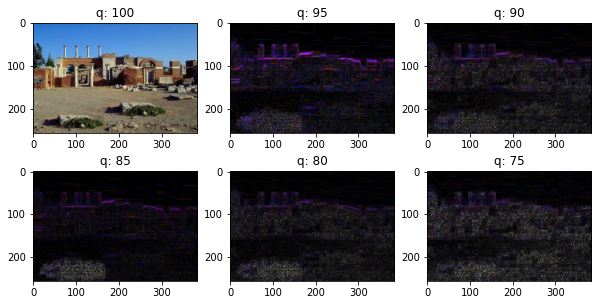

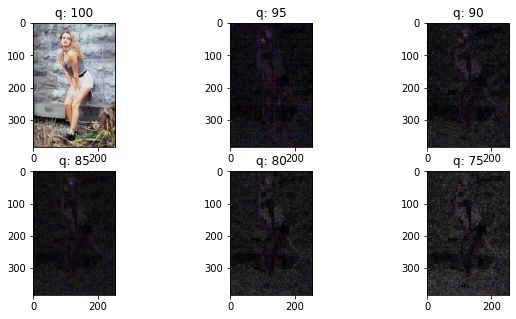

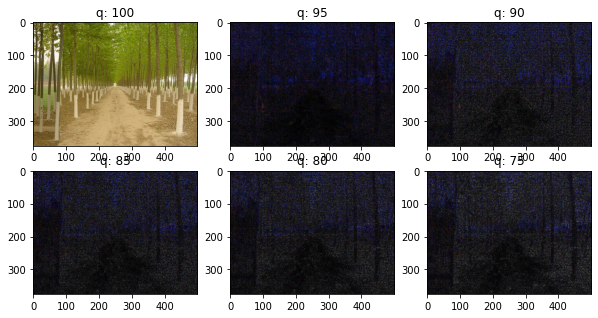

In [ ]:
p = os.path.join('Casia2', 'Tampered/')
temp = p
p = os.listdir(p)
#print(p)

for i in range(0,5):
    random_img = temp+random.choice(p)
    original = cv2.cvtColor(cv2.imread(random_img),cv2.COLOR_BGR2RGB)/255.0
    init_value  = 100
    c = 3
    r = 2

    fig=plt.figure(figsize=(10, 5))
    for i in range(1, c*r +1):
        quality = init_value - (i-1) * 5
        img = convert_to_ela_image(path=random_img, quality=quality)
        if i == 1:
            img = original.copy()
        ax = fig.add_subplot(r, c, i) 
        ax.title.set_text(f'q: {quality}')
        plt.imshow(img)
    plt.show()

*Result on Tampered image clearly highlights the different contrast among edges. Although Uniform coloured pixels are reduces to lower values, surface do not have uniformity in textures.*

Various Compression Quality values affects the resultant ELA differenlty. Although as we lower the value of quality, there isnt much substantial difference between the earlier and current resave. Hence, Quality can be anything above 80, and purely subjective.

*Code for trackbar tweaking:*
[link text](https://)

In [ ]:
'''
Function for data preprocessing
  1. Convert to ELA
  2. Resize
  3. Flatten
  4. Normalize
'''

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize((128,128))).flatten() / 255.0

CASIA2.0 Has .jpg, .tig, and some of .bmp and .png images. Everything else tha .jpg(and .jpeg) is redundant, since we are applying ELA. 

Error Level Analysis works only with lossy compressions(jpg).

In [ ]:
X = []
Y = []

Real_path = 'Casia2/Real/'
Tampered_path = 'Casia2/Tampered/'

paths = [Real_path,Tampered_path] 

label = 0
for i in paths:
    print(f"Processing {i} Images:")
    for name in os.listdir(i):
        img_path = os.path.join(i,name)
        if img_path.endswith('.jpeg') or img_path.endswith('.jpg'):
            img = prepare_image(image_path=img_path)
            X.append(img)
            Y.append(label)
            if len(Y)%1000==0: 
                print(f"\tProcessed {len(Y)} images")
    label=1

Processing Casia2/Real/ Images:
	Processed 1000 images
	Processed 2000 images
	Processed 3000 images
	Processed 4000 images
	Processed 5000 images


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  warnings.warn(


	Processed 6000 images
	Processed 7000 images
Processing Casia2/Tampered/ Images:
	Processed 8000 images
	Processed 9000 images


In [ ]:
print("Total no of Real Images: ",Y.count(0))
print("Total no of Tampered Images: ",Y.count(1))

Total no of Real Images:  7437
Total no of Tampered Images:  2064


In [ ]:
from keras.utils.np_utils import to_categorical

X = np.array(X).astype("float64")
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

**Data Imbalance**

Dropping 5000 samples from X to balance the data

This we can use for testing

In [ ]:
X_test = X[:5000]
Y_test = Y[:5000]

Y = Y[5000:]
X = X[5000:]

Saving Data

In [ ]:
np.save('ELA_Data/X',X)
np.save('ELA_Data/Y',Y)
np.save('ELA_Data/X_test',X_test)
np.save('ELA_Data/Y_test',Y_test)

Loading Data

In [ ]:
X = np.load('ELA_Data/X.npy')
Y = np.load('ELA_Data/Y.npy')

Split the new X and Y into training and validation data using train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.20, random_state=5)
X = X.reshape(-1,1,1,1)

In [ ]:
#verify
print(len(X_train) , len(Y_train) )
print(len(X_val) , len(Y_val))
print(Y_val[:15])

3600 3600
901 901
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
models = {'densenet': DenseNet121}

Setting the configurations for Epochs; Batch_size; Initial LR etc.

In [ ]:
class Config:
    epochs = 30
    batch_size = 32
    lr = 1e-4
    name = 'densenet'
    n_labels = 2
    image_size = (128, 128)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
import tensorflow as tf
from tensorflow.keras import Sequential,Model

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),tf.keras.metrics.AUC(name='auc')]

DenseNet121; No layers have been freeze, since the prior one is trained on imagenet classification task, we have use of it, we are just borrowing the architecture.

Adding FC with 1024

Added Output Layer with 2 Nodes

In [ ]:
base_model = models['densenet'](include_top=False, weights='imagenet', input_shape=(128, 128, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
    
model = Model(base_model.inputs, output)
    
model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr=Config.lr, 
                momentum=Config.momentum, 
                nesterov=Config.nesterov),
                metrics=METRICS)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


LearningRateScheduling, which decreases LR after 10 epoch by 10%. (Results stopped improving at 5 )

In [ ]:
def scheduler(epoch):
    if epoch < 10:
      return Config.lr
    else:
      return Config.lr * (0.9)   

In [ ]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

reduce_lr = LearningRateScheduler(scheduler)
callbacks_all = [reduce_lr]


In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=Config.epochs,
    batch_size=Config.batch_size,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_all
)

Epoch 1/30
113/113 [==============================] - 41s 186ms/step - loss: 0.5128 - accuracy: 0.7428 - auc: 0.8236 - val_loss: 0.7475 - val_accuracy: 0.5416 - val_auc: 0.5466 - lr: 1.0000e-04
Epoch 2/30
113/113 [==============================] - 16s 140ms/step - loss: 0.2595 - accuracy: 0.9006 - auc: 0.9613 - val_loss: 0.7999 - val_accuracy: 0.5161 - val_auc: 0.5362 - lr: 1.0000e-04
Epoch 3/30
113/113 [==============================] - 16s 140ms/step - loss: 0.1851 - accuracy: 0.9336 - auc: 0.9819 - val_loss: 0.6974 - val_accuracy: 0.6249 - val_auc: 0.6849 - lr: 1.0000e-04
Epoch 4/30
113/113 [==============================] - 16s 141ms/step - loss: 0.1313 - accuracy: 0.9547 - auc: 0.9924 - val_loss: 0.4569 - val_accuracy: 0.7913 - val_auc: 0.8707 - lr: 1.0000e-04
Epoch 5/30
113/113 [==============================] - 16s 138ms/step - loss: 0.1015 - accuracy: 0.9669 - auc: 0.9962 - val_loss: 0.2557 - val_accuracy: 0.9068 - val_auc: 0.9594 - lr: 1.0000e-04
Epoch 6/30
113/113 [==========

# **Results and Analysis**

**1. Loss**

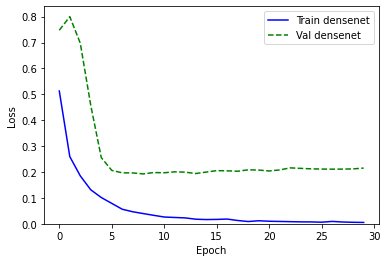

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.plot(history.epoch, history.history['loss'],
               color='blue', label='Train ' + label)
    plt.plot(history.epoch, history.history['val_loss'],color='green', label='Val ' + label,linestyle="--")
    plt.ylim([0, plt.ylim()[1]])         
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, Config.name, 0)

Loss itselfs starts very low for both training and validation. .5 and .9 respectively. Loss shows tremendous drop at initial epochs upto 5. Then it stops decreasing and gives us a flatline.

**2. AUC**

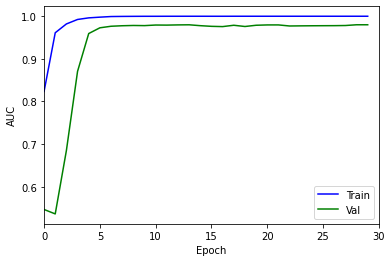

In [ ]:
plt.plot(history.epoch, history.history['auc'], color='blue', label='Train')
plt.plot(history.epoch, history.history['val_auc'],color='green', label='Val')
plt.xlabel('Epoch')
plt.xlim([0,30])
plt.ylabel('AUC')
plt.legend()

AUC curve shows high growth in initial epochs till 5. Then both, for training and validation, stopped improving and became flatline.

**3. Accuracy**

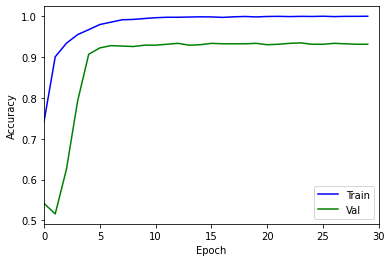

In [ ]:
plt.plot(history.epoch, history.history['accuracy'], color='blue', label='Train')
plt.plot(history.epoch, history.history['val_accuracy'],color='green', label='Val')
plt.xlabel('Epoch')
plt.xlim([0,30])
plt.ylabel('Accuracy')
plt.legend()

Accuracy curve as well shows high improvement in initial epochs till 5. Then again both, for training and validation, stopped improving and became flatline, yeilding max_val_acc of 93.78.

In [ ]:
import itertools
from sklearn.metrics import roc_curve, roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Loading the data we splitted earlier for Testing. (5000 Real Images)
NOTE: The testing conducted at this location solely considers authentic images, but if you wish to identify manipulated ones, you can create a brief script to accomplish that.

In [ ]:
X_test = np.load('ELA_Data/X_test.npy')
Y_test = np.load('ELA_Data/Y_test.npy')

In [ ]:
from sklearn.metrics import confusion_matrix

#predictions on the testing data -> categorical output of shape (len,2)
Y_pred = model.predict(X_test)

157/157 [==============================] - 8s 39ms/step


In [ ]:
#argmax idx among class 0 and 1
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 

In [ ]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

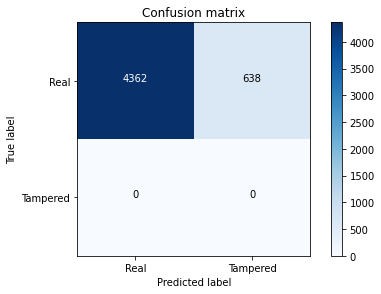

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = ['Real','Tampered'])

In [ ]:
model.save('ELA_Model_.h5')